# Análisis de las señales usando inferencia bayesiana

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
sns.set()
import pandas as pd

import theano.tensor as TT
import time
import random

import pymc3 as pm
import arviz as az

import sys

%run /home/tele/Desktop/UWB/codigos_auxiliares/Bayes2.ipynb

In [3]:
portadoras = ['Fc7/','Fc8/']
mediciones = ['27_05','09_06','15_07']
alturas = ['1/','2/','3/','4/']

In [4]:
# path_Scal = '/home/tele/Desktop/UWB/mediciones_'+dia+'/S1/'


día 27_05

fc = 8.748GHz
# mediciones = 5


long de una medición S1: (440, 11)
dim S1: (5, 440, 11)
dim. S1_avg = (5, 440)
dim. S1_avg = (5, 103)
f_min = 3.0 GHz
Scal:  (380,)
# mediciones = 10


long de una medición S2: (284, 11)
(10, 284, 11)
3000000000.0
(380,)
Comparo Scal y Star




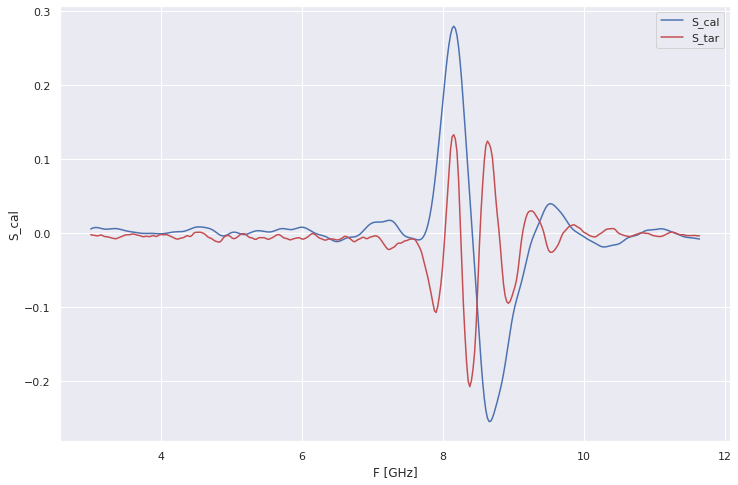

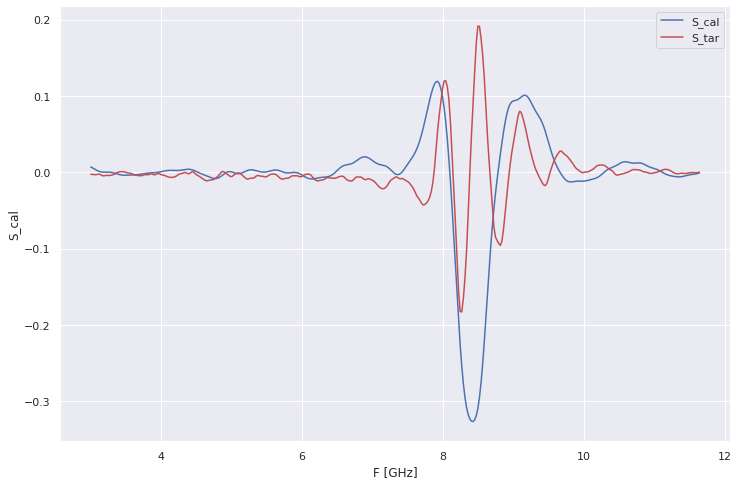

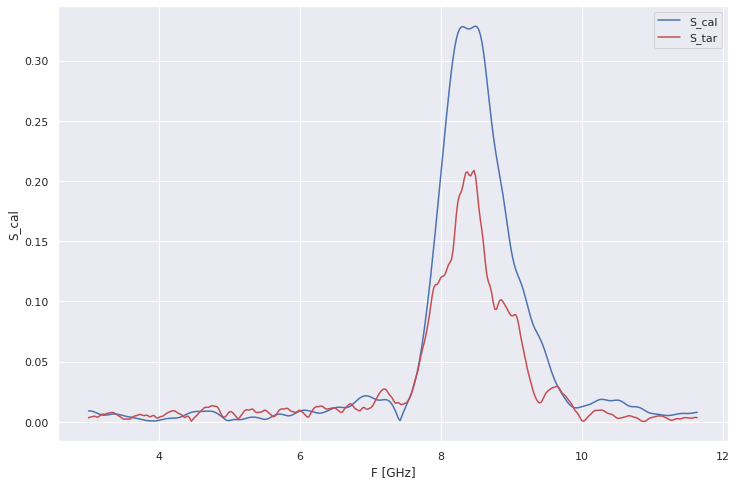

--fin día27_05--
-------------------------------------------------




In [198]:
# for j in range(3):
portadora = portadoras[1]
dia_cal = mediciones[2]
dia_tar = mediciones[0]
altura = alturas[1]

path_Scal = '/home/tele/Desktop/UWB/mediciones_'+dia_cal+'/S1/'
path_Star = '/home/tele/Desktop/UWB/mediciones_'+dia_tar+'/S2/'

print('día '+dia_tar)
print()
%run analisis_seniales2.ipynb
print('--fin día'+dia_tar+'--')
print('-------------------------------------------------')
print()
print()

## Cargo las mediciones

In [199]:
## Señal de Calibración
Scal = np.load('Scal.npy',mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
print('dim Scal:',np.shape(Scal)[0])
print()

## Señal del target
Star = np.load('Star.npy',mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
print('dim Star:',np.shape(Star)[0])
print()

## Frecuencias positivas obtenidas de la FFT
fpos = np.load('fpos.npy',mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
print('dim fpos:',np.shape(fpos)[0])

dim Scal: 380

dim Star: 380

dim fpos: 380


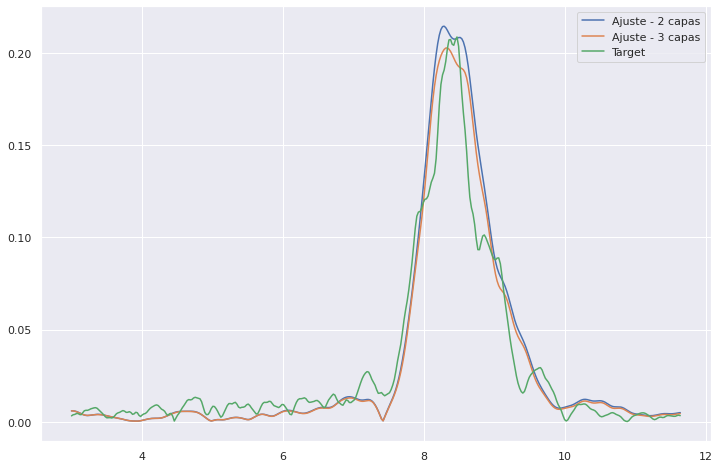

In [200]:
## hago un ajuste rápido con el modelo de Pinel para ver si tiene buena pinta

%run /home/tele/Desktop/UWB/codigos_auxiliares/Pinel.ipynb
# R_pinel_2L(ep1,ep2,d1,s0,s1,f)
#R_pinel_3L(ep1,ep2,ep3,d1,d2,s0,s1,s2,f,n_layers):

ajuste_2L = np.abs(Scal*R_pinel_2L(20+1j*7,23+1j*7,0.065,1e-3,1.5e-4,f_pos))
ajuste_3L = np.abs(Scal*R_pinel_3L(20+1j*7,23+1j*8,25+1j*9,0.065,0.12,1e-3,1.5e-4,0.5e-4,f_pos))
X2 = np.abs(Star)

plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,ajuste_2L,label="Ajuste - 2 capas")
plt.plot(f_pos/1e9,ajuste_3L,label="Ajuste - 3 capas")
plt.plot(f_pos/1e9,X2,label="Target")
plt.legend(loc = "best")
plt.show()

# Ajustes con el esquema bayesiano:
 - sin rugosidad ---> busco $\{ \epsilon_\,,\,d_n \}$ óptimos en el coeficiente de Fresnel
 - con rugosidad ---> busco $\{ \epsilon_\,,\,d_n, h_n \}$ óptimos en el modelo de Pinel

## - Un solo dieléctrico

In [201]:
NLayers = 1

# mayo
ep1_obs = 20.8 + 1j*7
#----------------------##

# # junio
# ep1_obs = 11.3 +1j*3


# # julio
# ep1_obs = 8.12 +1j*4


## skin depth para la portadora con ep1 medido
landa = 3e8/fc
print('long. onda portadora:',str(round(100*landa,2))+'cm')
delta_d = 2*np.real(ep1_obs)*2e8/(2*np.pi*(fc)*np.imag(ep1_obs))
print('Skin Depth a Fc:', str(round(100*delta_d,2))+'cm')
print()
print()

landa_max = 3e8/(fc-BW)
print('long. onda max:',str(round(100*landa_max,2))+'cm')
delta_max = 2*np.real(ep1_obs)*2e8/(2*np.pi*(fc-BW)*np.imag(ep1_obs))
print('Skin Depth a long. onda max:', str(round(100*delta_max,2))+'cm')
print()

long. onda portadora: 3.43cm
Skin Depth a Fc: 2.16cm


long. onda max: 4.14cm
Skin Depth a long. onda max: 2.61cm



In [202]:
%run /home/tele/Desktop/UWB/codigos_auxiliares/Bayes2.ipynb

t0 = time.time()
# nro de muestras que va a utilizar el método
noise_level = 2.25e-2
muestras = 5000
# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))


# inferencia bayesiana
#traza_sim_1layer, ppc, model = modelo(-Star,muestras,sigmas,NLayers)
traza_sim_1layer = modelo(Star,muestras,sigmas,NLayers,False)


t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well a

Tiempo insumido - Inf. Bayesiana: 9.12 seg (0.15 min)


Graficando con un solo dieléctrico ...

input ep1_r:  20.8
output ep1_r:  8.579±2.249

input ep1_i:  7.0
output ep1_i:  5.864±1.43

Tiempo insumido - Gráficos: 0.43 seg (0.01 min)

Tiempo insumido - TOTAL: 11.81 seg (0.2 min)





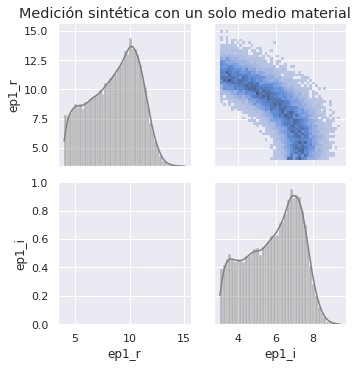

In [203]:
t2 = time.time()
print('Graficando con un solo dieléctrico ...')

ep1_r_mean = round(np.mean(traza_sim_1layer['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_1layer['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_1layer['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_1layer['ep1_i']),3)

# plotear = np.stack((traza['ep1'], traza['ep2'], traza['d'], traza['s1'], traza['s2'])).T 
# dfplotear = pd.DataFrame(plotear, columns = ['ep1','ep2','d','s1','s2'])

plotear = np.stack((traza_sim_1layer['ep1_r'], traza_sim_1layer['ep1_i'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r', 'ep1_i'])


g = sns.PairGrid(dfplotear)
g.fig.suptitle('Medición sintética con un solo medio material', y=1.01, fontsize = 'large')
g.map_upper(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
# g.axes[0,0].axvline(np.real(ep1_obs), color='r', linestyle='solid', linewidth=0.5)
# g.axes[1,0].scatter(np.real(ep1_obs), np.imag(ep1_obs), marker="+", c='r', s=200)
# g.axes[1,1].axvline(np.imag(ep1_obs), color='r', linestyle='solid', linewidth=0.5)


print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+"\u00B1"+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+"\u00B1"+str(ep1_i_std))
print()

t3 = time.time()
print('Tiempo insumido - Gráficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()


input ep1_r:  20.8
output ep1_r:  8.579±2.249

input ep1_i:  7.0
output ep1_i:  5.864±1.43



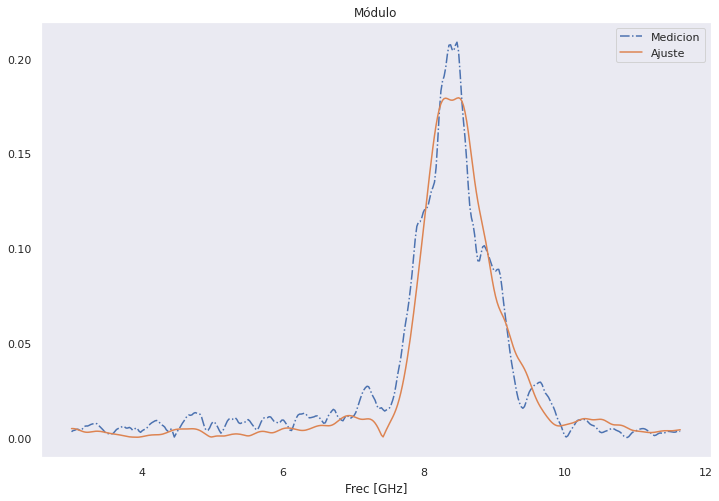

In [204]:
EP1 = ep1_r_mean + 1j*ep1_i_mean
S_fit = Scal*R_ep(EP1)




print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+"\u00B1"+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+"\u00B1"+str(ep1_i_std))
print()


plt.figure(figsize=(12,8))
plt.plot(fpos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(fpos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.title('Módulo')
plt.legend(loc="best")
plt.show()

# fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

# ax[0].plot(fpos/1e9,np.real(Star),'-.',label="Medicion")
# ax[0].plot(fpos/1e9,np.real(S_fit),label="Ajuste")
# ax[0].grid()
# ax[0].set_xlabel('Frec [GHz]')
# ax[0].set_title('Parte Real')
# ax[0].legend(loc="best")

# ax[1].plot(fpos/1e9,np.imag(Star),'-.',label="Medicion")
# ax[1].plot(fpos/1e9,np.imag(S_fit),label="Ajuste")
# ax[1].grid()
# ax[1].set_xlabel('Frec [GHz]')
# ax[1].set_title('Parte Imag.')
# ax[1].legend(loc="best")

# ax[2].plot(fpos/1e9,np.abs(Star),'-.',label="Medicion")
# ax[2].plot(fpos/1e9,np.abs(S_fit),label="Ajuste")
# ax[2].grid()
# ax[2].set_xlabel('Frec [GHz]')
# ax[2].set_title('Módulo')
# ax[2].legend(loc="best")
# plt.show()

In [24]:
# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

In [25]:
# from matplotlib.pyplot import figure

# g1 = figure(figsize=(18, 8), dpi=80)

# plt.plot(fpos,np.real(S_sim_ruido),linewidth=2, c='r', label='obs')

# alphaPPC = 0.3

# ppc_mean = ppc['S2_med'][0].mean(axis = 0)

# plt.plot(fpos, ppc_mean, alpha = 0.8, linewidth=2, c='b', label='sample mean')

# for i in range(10):
#     plt.plot(fpos, ppc['S2_med'][i,0,:], ':k', alpha = alphaPPC,  label='sample')
#     # plt.plot(thi*180/pi, ppc['obs'][0,:], ':k', alpha = alphaPPC,  label='sample #1')
#     # plt.plot(thi*180/pi, ppc['obs'][4,:], ':k', alpha = alphaPPC, label='sample #2')
#     # plt.plot(thi*180/pi, ppc['obs'][8,:], ':k', alpha = alphaPPC, label='sample #3')

# plt.legend()

# - Dos dieléctricos

In [206]:
NLayers = 2

# mayo
ep1_obs = 20.8 + 1j*7
ep2_obs = 25 + 1j*8
d_obs = 12e-2
#----------------------##

# # junio
# ep1_obs = 11.3 +1j*3
# ep2_obs = 16 + 1j*5
# d2_obs = 13e-2


# # julio
# ep1_obs = 8.12 +1j*4
# ep2_obs = 11.3 + 1j*5
# d_obs = 0.14


## Sin rugosidad

In [208]:
t0 = time.time()

# nro de muestras que va a utilizar el método
muestras = 7500
noise_level = 2.25e-2

# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))


# inferencia bayesiana
traza_sim_2layers = modelo(Star,muestras,sigmas,NLayers,rug=False)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as b

Tiempo insumido - Inf. Bayesiana: 35.35 seg (0.59 min)


Graficando para 2 layers ...


input ep1_r:  20.8
output ep1_r:  8.895±3.029

input ep1_i:  7.0
output ep1_i:  5.734±1.126

input ep2_r:  25.0
output ep2_r:  29.609±7.279

input ep2_i:  8.0
output ep2_i:  8.489±1.438

input d:  0.12
output d:  0.004±0.002



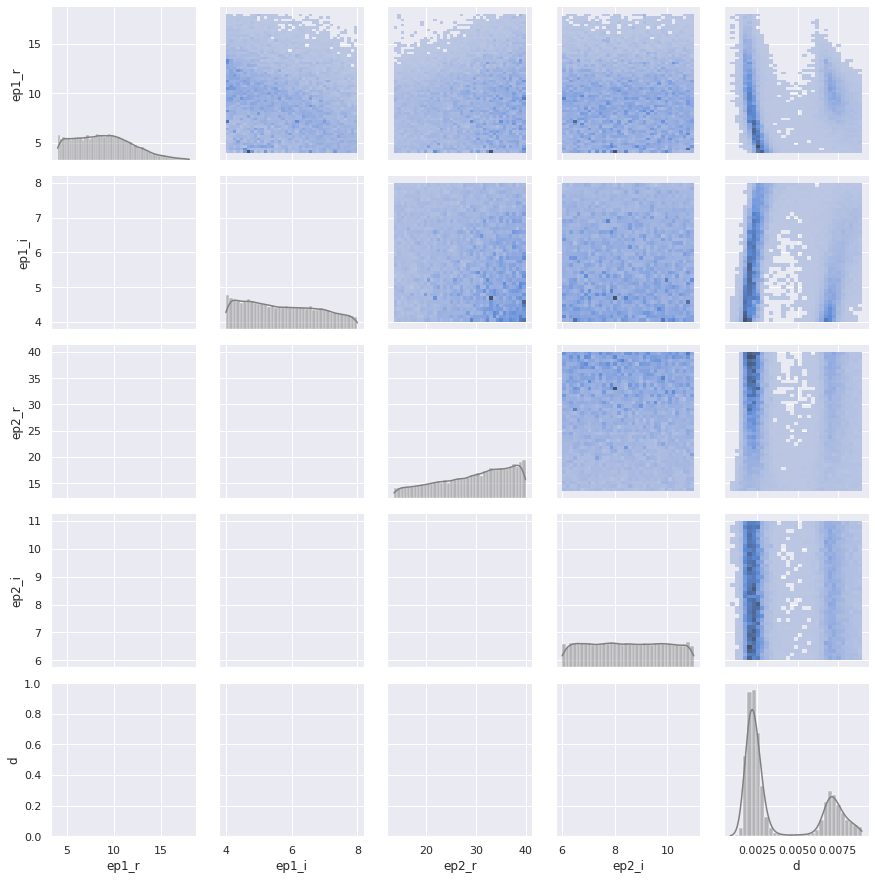

In [209]:
#Ploteo
print('Graficando para 2 layers ...')
print()

ep1_r_mean = round(np.mean(traza_sim_2layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_2layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_2layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_2layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_2layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_2layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_2layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_2layers['ep2_i']),3)

d_mean = round(np.mean(traza_sim_2layers['d']),3)
d_std = round(np.std(traza_sim_2layers['d']),3)



plotear = np.stack((traza_sim_2layers['ep1_r'], traza_sim_2layers['ep1_i'], traza_sim_2layers['ep2_r'], 
                    traza_sim_2layers['ep2_i'], traza_sim_2layers['d'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep1_i','ep2_r','ep2_i','d'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
#g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')

# g.axes[0,0].axvline(np.real(ep1_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[1,1].axvline(np.imag(ep1_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[2,2].axvline(np.real(ep2_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[3,3].axvline(np.imag(ep2_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[4,4].axvline(d_s, color='r', linestyle='solid', linewidth=0.5)

# g.axes[1,0].scatter(np.real(ep1_s), np.imag(ep1_s), marker="+", c='r', s=200)
# g.axes[2,0].scatter(np.real(ep1_s), np.real(ep2_s), marker="+", c='r', s=200)
# g.axes[3,0].scatter(np.real(ep1_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,0].scatter(np.real(ep1_s), d_s, marker="+", c='r', s=200)

# g.axes[2,1].scatter(np.imag(ep1_s), np.real(ep2_s), marker="+", c='r', s=200)
# g.axes[3,1].scatter(np.imag(ep1_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,1].scatter(np.imag(ep1_s), d_s, marker="+", c='r', s=200)

# g.axes[3,2].scatter(np.real(ep2_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,2].scatter(np.real(ep2_s), d_s, marker="+", c='r', s=200)

# g.axes[4,3].scatter(np.imag(ep2_s), d_s, marker="+", c='r', s=200)


print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+"\u00B1"+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+"\u00B1"+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+"\u00B1"+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+"\u00B1"+str(ep2_i_std))
print()
print('input d: ', d_obs)
print('output d: ', str(d_mean)+"\u00B1"+str(d_std))
print()

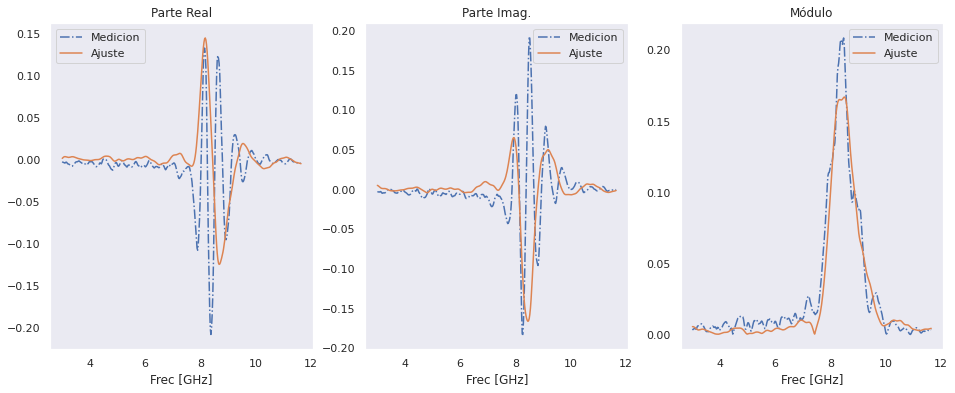

In [210]:
EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
Dis = d_mean

S_fit = Scal*R_ep1_ep2(EP1,EP2,Dis,fpos)

fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(fpos/1e9,np.real(Star),'-.',label="Medicion")
ax[0].plot(fpos/1e9,np.real(S_fit),label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(fpos/1e9,np.imag(Star),'-.',label="Medicion")
ax[1].plot(fpos/1e9,np.imag(S_fit),label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(fpos/1e9,np.abs(Star),'-.',label="Medicion")
ax[2].plot(fpos/1e9,np.abs(S_fit),label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()

## Con rugosidad

In [211]:
%run /home/tele/Desktop/UWB/codigos_auxiliares/Pinel.ipynb
%run /home/tele/Desktop/UWB/codigos_auxiliares/Bayes2.ipynb

t0 = time.time()

# nro de muestras que va a utilizar el método
muestras = 5500
noise_level = 2.5e-2

# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))

# un solo medio dieléctrico
NLayers = 2


# inferencia bayesiana
traza_sim_2layers = modelo(Star,muestras,sigmas,NLayers,True)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as 

Tiempo insumido - Inf. Bayesiana: 72.03 seg (1.2 min)


Graficando para dos dieléctricos + rugosidad (esto puede demorar...)


input ep1_r:  20.8
output ep1_r:  10.906±1.045

input ep1_i:  7.0
output ep1_i:  4.109±1.147

input ep2_r:  25.0
output ep2_r:  24.89±3.061

input ep2_i:  8.0
output ep2_i:  5.517±1.396

input d:  0.06
output d:  0.075±0.005

input s1: ---
output s1:  0.00086±0.000522

input s2: ---
output s2:  0.00044±0.000229



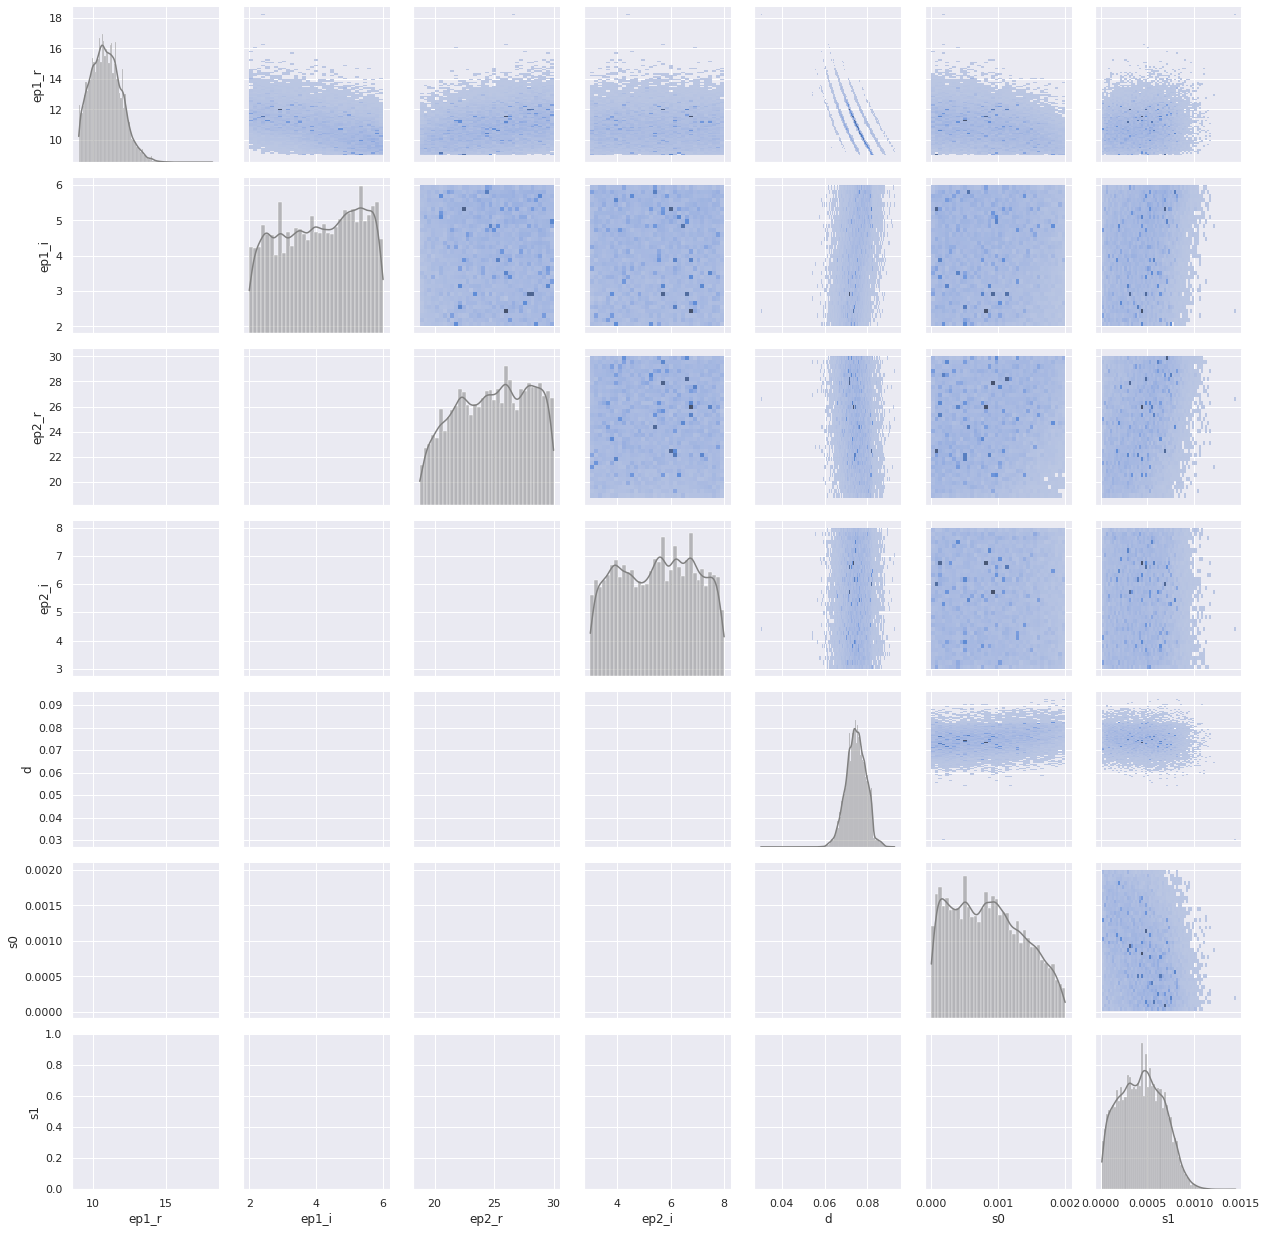

In [212]:
#Ploteo
print('Graficando para dos dieléctricos + rugosidad (esto puede demorar...)')
print()

ep1_r_mean = round(np.mean(traza_sim_2layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_2layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_2layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_2layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_2layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_2layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_2layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_2layers['ep2_i']),3)

d_mean = round(np.mean(traza_sim_2layers['d']),3)
d_std = round(np.std(traza_sim_2layers['d']),3)

s1_mean = round(np.mean(traza_sim_2layers['s0']),5)
s1_std = round(np.std(traza_sim_2layers['s0']),6)

s2_mean = round(np.mean(traza_sim_2layers['s1']),5)
s2_std = round(np.std(traza_sim_2layers['s1']),6)



plotear = np.stack((traza_sim_2layers['ep1_r'], traza_sim_2layers['ep1_i'], traza_sim_2layers['ep2_r'], 
                    traza_sim_2layers['ep2_i'], traza_sim_2layers['d'],traza_sim_2layers['s0'],traza_sim_2layers['s1'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep1_i','ep2_r','ep2_i','d','s0','s1'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
# g.map_lower(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')

# g.axes[0,0].axvline(np.real(ep1_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[1,1].axvline(np.imag(ep1_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[2,2].axvline(np.real(ep2_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[3,3].axvline(np.imag(ep2_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[4,4].axvline(d_s, color='r', linestyle='solid', linewidth=0.5)

# g.axes[1,0].scatter(np.real(ep1_s), np.imag(ep1_s), marker="+", c='r', s=200)
# g.axes[2,0].scatter(np.real(ep1_s), np.real(ep2_s), marker="+", c='r', s=200)
# g.axes[3,0].scatter(np.real(ep1_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,0].scatter(np.real(ep1_s), d_s, marker="+", c='r', s=200)

# g.axes[2,1].scatter(np.imag(ep1_s), np.real(ep2_s), marker="+", c='r', s=200)
# g.axes[3,1].scatter(np.imag(ep1_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,1].scatter(np.imag(ep1_s), d_s, marker="+", c='r', s=200)

# g.axes[3,2].scatter(np.real(ep2_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,2].scatter(np.real(ep2_s), d_s, marker="+", c='r', s=200)

# g.axes[4,3].scatter(np.imag(ep2_s), d_s, marker="+", c='r', s=200)


print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+"\u00B1"+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+"\u00B1"+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+"\u00B1"+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+"\u00B1"+str(ep2_i_std))
print()
print('input d: ', d_s)
print('output d: ', str(d_mean)+"\u00B1"+str(d_std))
print()
print('input s1: ---')
print('output s1: ', str(s1_mean)+"\u00B1"+str(s1_std))
print()
print('input s2: ---')
print('output s2: ', str(s2_mean)+"\u00B1"+str(s2_std))
print()

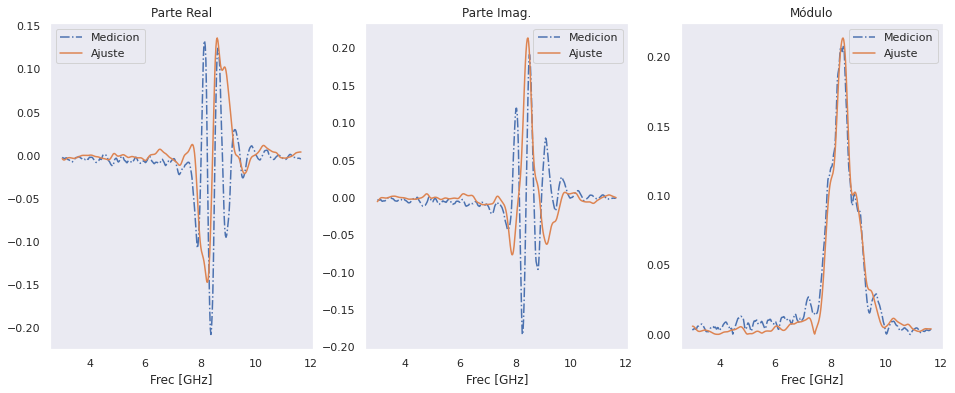

In [213]:
EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
Dist = d_mean
S1_opt = s1_mean
S2_opt = s2_mean

S_fit = Scal*R_pinel(EP1,EP2,1,Dist,1,S1_opt,S2_opt,1,fpos,NLayers) # señal 'medida'


fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(fpos/1e9,np.real(Star),'-.',label="Medicion")
ax[0].plot(fpos/1e9,np.real(S_fit),label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(fpos/1e9,np.imag(Star),'-.',label="Medicion")
ax[1].plot(fpos/1e9,np.imag(S_fit),label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(fpos/1e9,np.abs(Star),'-.',label="Medicion")
ax[2].plot(fpos/1e9,np.abs(S_fit),label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()

# - Tres dieléctricos

In [214]:
NLayers = 3

# mayo
ep1_obs = 18 + 1j*4  # dieléctrico
ep2_obs = 23.5 + 1j*5
ep3_obs = 26 + 1j*5
d1_obs = 6e-2
d2_obs = 12e-2
#----------------------#

# # junio
# ep1_obs = 11.3 +1j*3
# ep2_obs = 16 + 1j*5
# ep3_obs = 23 + 1j*9
# d1_obs =  9e-2
# d2_obs = 13e-2


# # julio
# ep1_obs = 8 + 1j*4
# ep2_obs = 10 +1j*5
# ep3_obs = 12.3 + 1j*6
# d1_obs =  2e-2
# d2_obs = 7e-2

## Sin rugosidad

In [215]:
%run /home/tele/Desktop/UWB/codigos_auxiliares/Pinel.ipynb
%run /home/tele/Desktop/UWB/codigos_auxiliares/Bayes2.ipynb

t0 = time.time()

# nro de muestras que va a utilizar el método
muestras = 2500
noise_level = 2.5e-2

# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))

# un solo medio dieléctrico
NLayers = 3


# inferencia bayesiana
traza_sim_3layers = modelo(Star,muestras,sigmas,NLayers,rug=False)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as b

Tiempo insumido - Inf. Bayesiana: 32.13 seg (0.54 min)


Graficando para tres dieléctricos (esto puede demorar...)


input ep1_r:  18.0
output ep1_r:  16.36±0.334

input ep1_i:  4.0
output ep1_i:  2.461±0.503

input ep2_r:  23.5
output ep2_r:  24.277±3.525

input ep2_i:  5.0
output ep2_i:  6.224±1.142

input ep3_r:  26.0
output ep3_r:  29.41±3.216

input ep3_i:  5.0
output ep3_i:  6.999±1.716

input d1:  0.06
output d1:  0.014±0.007

input d2:  0.12
output d2:  0.105±0.026

tiempo:48.22629451751709seg (0.8037715752919515min)


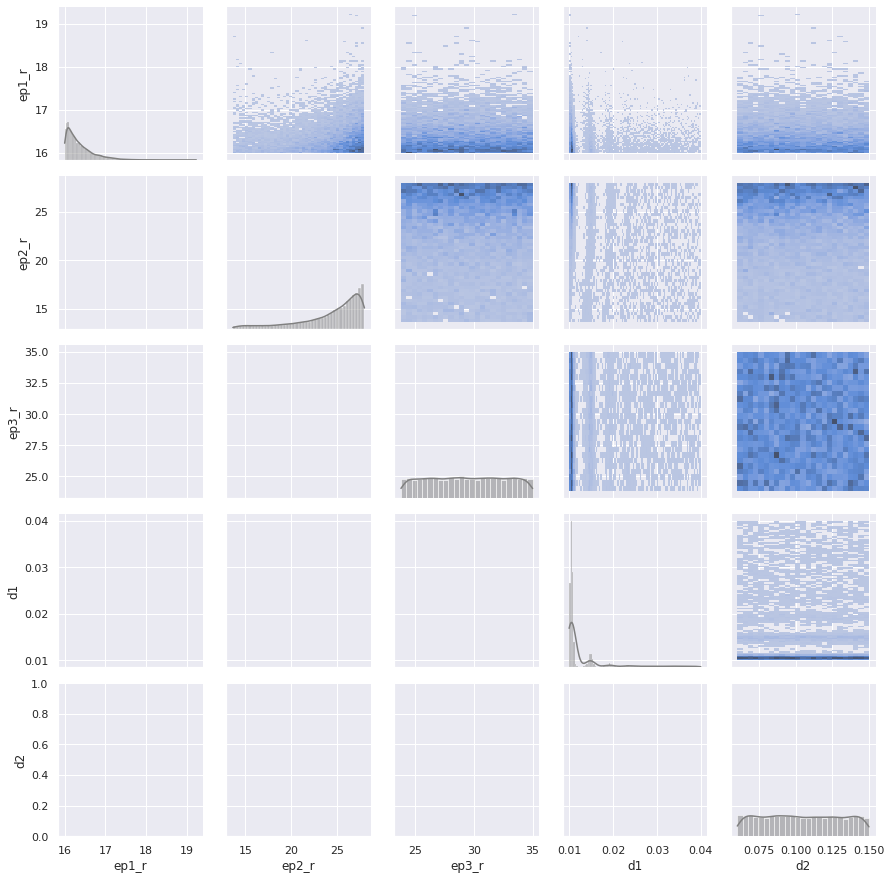

In [216]:
#Ploteo
print('Graficando para tres dieléctricos (esto puede demorar...)')
print()

ep1_r_mean = round(np.mean(traza_sim_3layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_3layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_3layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_3layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_3layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_3layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_3layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_3layers['ep2_i']),3)

ep3_r_mean = round(np.mean(traza_sim_3layers['ep3_r']),3)
ep3_r_std = round(np.std(traza_sim_3layers['ep3_r']),3)

ep3_i_mean = round(np.mean(traza_sim_3layers['ep3_i']),3)
ep3_i_std = round(np.std(traza_sim_3layers['ep3_i']),3)

d1_mean = round(np.mean(traza_sim_3layers['d1']),3)
d1_std = round(np.std(traza_sim_3layers['d1']),3)

d2_mean = round(np.mean(traza_sim_3layers['d2']),3)
d2_std = round(np.std(traza_sim_3layers['d2']),3)



print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+"\u00B1"+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+"\u00B1"+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+"\u00B1"+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+"\u00B1"+str(ep2_i_std))
print()
print('input ep3_r: ', np.real(ep3_obs))
print('output ep3_r: ', str(ep3_r_mean)+"\u00B1"+str(ep3_r_std))
print()
print('input ep3_i: ', np.imag(ep3_obs))
print('output ep3_i: ', str(ep3_i_mean)+"\u00B1"+str(ep3_i_std))
print()
print('input d1: ', d1_obs)
print('output d1: ', str(d1_mean)+"\u00B1"+str(d1_std))
print()
print('input d2: ', d2_obs)
print('output d2: ', str(d2_mean)+"\u00B1"+str(d2_std))
print()

plotear = np.stack((traza_sim_3layers['ep1_r'], traza_sim_3layers['ep2_r'], traza_sim_3layers['ep3_r'], 
                    traza_sim_3layers['d1'], traza_sim_3layers['d2'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep2_r','ep3_r','d1','d2'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
#g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
# g.savefig('Datos2/'+zonaMed+'-M='+str(muestras)+'e='+str(sigmas[0])+'.png')

t1 = time.time()
print('tiempo:'+str(t1-t0)+'seg', '('+str((t1-t0)/60)+'min)')


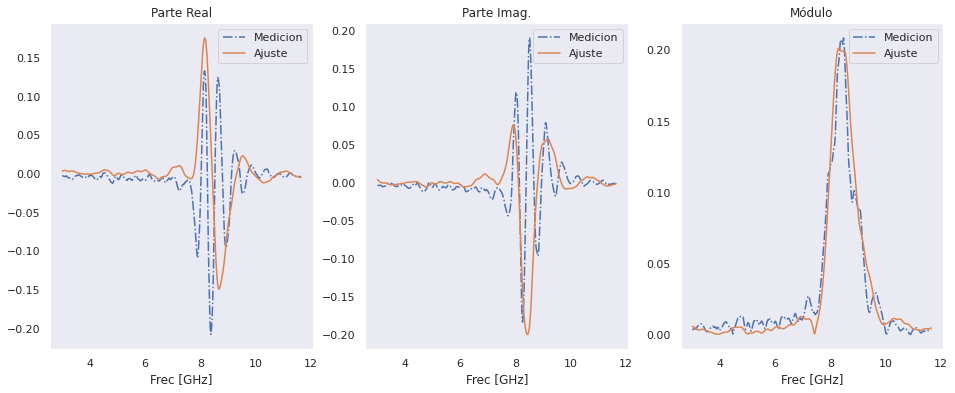

In [217]:
EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
EP3 = ep3_r_mean + 1j*ep3_i_mean
D1 = d1_mean
D2 = d2_mean

S_fit = Scal*R_ep1_ep2_ep3(EP1,EP2,EP3,D1,D2,fpos)

fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(fpos/1e9,np.real(Star),'-.',label="Medicion")
ax[0].plot(fpos/1e9,np.real(S_fit),label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(fpos/1e9,np.imag(Star),'-.',label="Medicion")
ax[1].plot(fpos/1e9,np.imag(S_fit),label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(fpos/1e9,np.abs(Star),'-.',label="Medicion")
ax[2].plot(fpos/1e9,np.abs(S_fit),label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()

## Con rugosidad

In [218]:
%run /home/tele/Desktop/UWB/codigos_auxiliares/Pinel.ipynb
%run /home/tele/Desktop/UWB/codigos_auxiliares/Bayes2.ipynb

t0 = time.time()

# nro de muestras que va a utilizar el método
muestras = 5000
noise_level = 2.5e-2

# error de la medición
sigmas = noise_level*np.ones((2,len(Star)))


# un solo medio dieléctrico
NLayers = 3


# inferencia bayesiana
traza_sim_3layers = modelo(Star,muestras,sigmas,NLayers,True)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op sqrt does not provide a C implementation. As well as 

Tiempo insumido - Inf. Bayesiana: 123.3 seg (2.06 min)


Graficando para dos dieléctricos + rugosidad (esto puede demorar...)


input ep1_r:  18.0
output ep1_r:  11.143±1.049

input ep1_i:  4.0
output ep1_i:  4.318±1.117

input ep2_r:  23.5
output ep2_r:  23.635±2.362

input ep2_i:  5.0
output ep2_i:  5.522±1.425

input ep3_r:  26.0
output ep3_r:  30.076±5.095

input ep3_i:  5.0
output ep3_i:  5.47±1.395

input d1:  0.06
output d1:  0.074±0.004

input d2:  0.12
output d2:  0.174±0.042



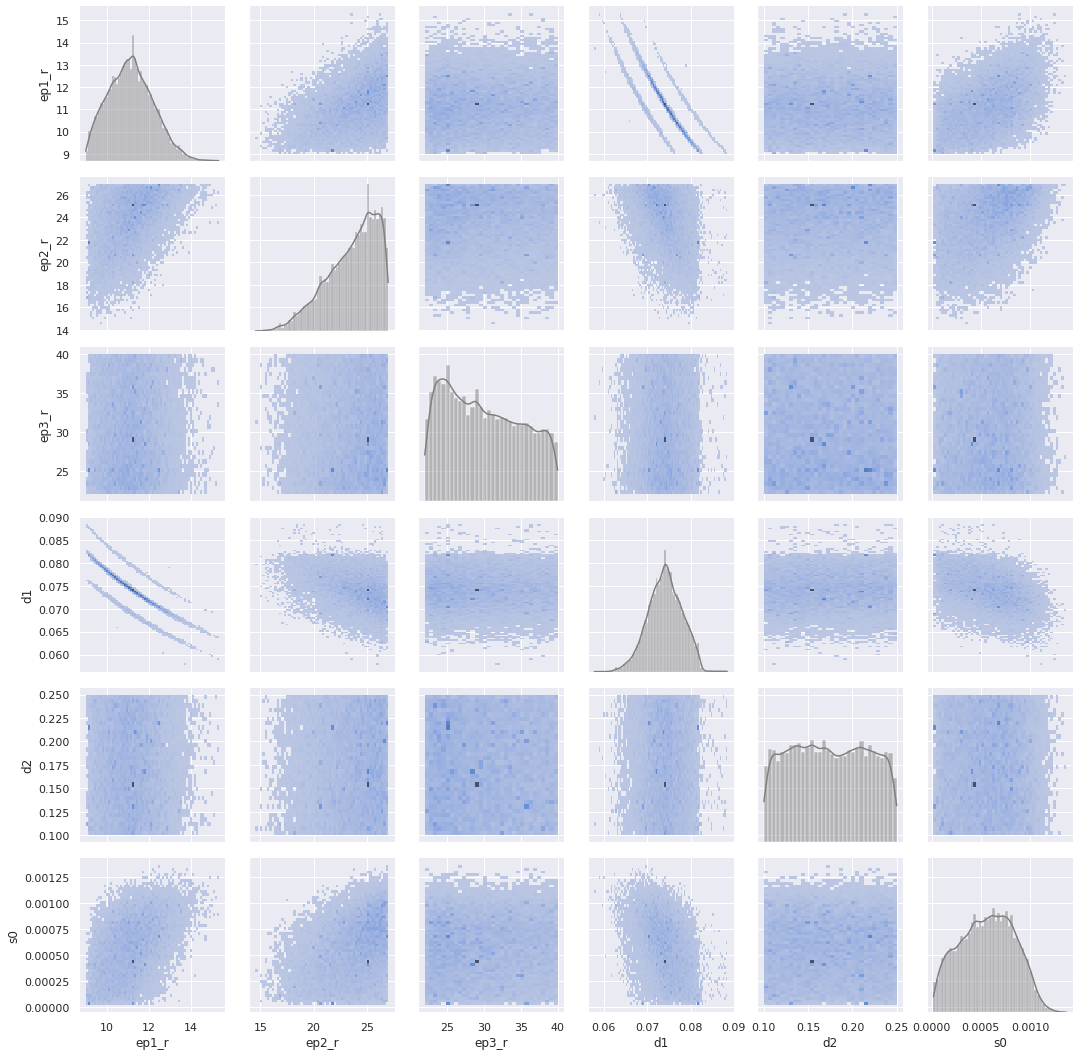

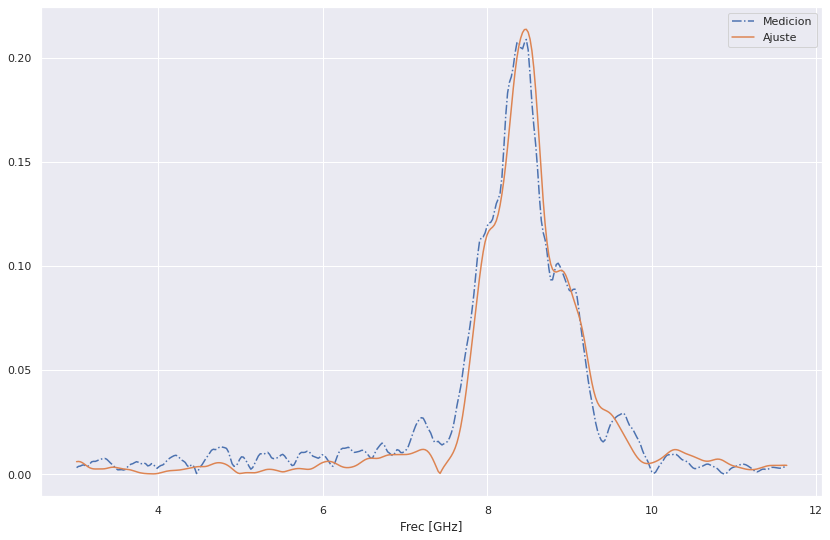

In [219]:


#Ploteo
print('Graficando para dos dieléctricos + rugosidad (esto puede demorar...)')
print()

ep1_r_mean = round(np.mean(traza_sim_3layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_3layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_3layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_3layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_3layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_3layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_3layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_3layers['ep2_i']),3)

ep3_r_mean = round(np.mean(traza_sim_3layers['ep3_r']),3)
ep3_r_std = round(np.std(traza_sim_3layers['ep3_r']),3)

ep3_i_mean = round(np.mean(traza_sim_3layers['ep3_i']),3)
ep3_i_std = round(np.std(traza_sim_3layers['ep3_i']),3)


d1_mean = round(np.mean(traza_sim_3layers['d1']),3)
d1_std = round(np.std(traza_sim_3layers['d1']),3)

d2_mean = round(np.mean(traza_sim_3layers['d2']),3)
d2_std = round(np.std(traza_sim_3layers['d2']),3)


s0_mean = round(np.mean(traza_sim_3layers['s0']),5)
s0_std = round(np.std(traza_sim_3layers['s0']),6)

s1_mean = round(np.mean(traza_sim_3layers['s1']),5)
s1_std = round(np.std(traza_sim_3layers['s1']),6)

s2_mean = round(np.mean(traza_sim_3layers['s2']),5)
s2_std = round(np.std(traza_sim_3layers['s2']),6)


print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+"\u00B1"+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+"\u00B1"+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+"\u00B1"+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+"\u00B1"+str(ep2_i_std))
print()
print('input ep3_r: ', np.real(ep3_obs))
print('output ep3_r: ', str(ep3_r_mean)+"\u00B1"+str(ep3_r_std))
print()
print('input ep3_i: ', np.imag(ep3_obs))
print('output ep3_i: ', str(ep3_i_mean)+"\u00B1"+str(ep3_i_std))
print()
print('input d1: ', d1_obs)
print('output d1: ', str(d1_mean)+"\u00B1"+str(d1_std))
print()
print('input d2: ', d2_obs)
print('output d2: ', str(d2_mean)+"\u00B1"+str(d2_std))
print()



plotear = np.stack((traza_sim_3layers['ep1_r'], traza_sim_3layers['ep2_r'], traza_sim_3layers['ep3_r'],
                    traza_sim_3layers['d1'],traza_sim_3layers['d2'],traza_sim_3layers['s0'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep2_r','ep3_r','d1','d2','s0'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
g.map_lower(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')

# g.axes[0,0].axvline(np.real(ep1_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[1,1].axvline(np.imag(ep1_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[2,2].axvline(np.real(ep2_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[3,3].axvline(np.imag(ep2_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[4,4].axvline(d_s, color='r', linestyle='solid', linewidth=0.5)

# g.axes[1,0].scatter(np.real(ep1_s), np.imag(ep1_s), marker="+", c='r', s=200)
# g.axes[2,0].scatter(np.real(ep1_s), np.real(ep2_s), marker="+", c='r', s=200)
# g.axes[3,0].scatter(np.real(ep1_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,0].scatter(np.real(ep1_s), d_s, marker="+", c='r', s=200)

# g.axes[2,1].scatter(np.imag(ep1_s), np.real(ep2_s), marker="+", c='r', s=200)
# g.axes[3,1].scatter(np.imag(ep1_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,1].scatter(np.imag(ep1_s), d_s, marker="+", c='r', s=200)

# g.axes[3,2].scatter(np.real(ep2_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,2].scatter(np.real(ep2_s), d_s, marker="+", c='r', s=200)

# g.axes[4,3].scatter(np.imag(ep2_s), d_s, marker="+", c='r', s=200)


# print()
# print('input ep1_r: ', np.real(ep1_obs))
# print('output ep1_r: ', str(ep1_r_mean)+"\u00B1"+str(ep1_r_std))
# print()
# print('input ep1_i: ', np.imag(ep1_obs))
# print('output ep1_i: ', str(ep1_i_mean)+"\u00B1"+str(ep1_i_std))
# print()
# print('input ep2_r: ', np.real(ep2_obs))
# print('output ep2_r: ', str(ep2_r_mean)+"\u00B1"+str(ep2_r_std))
# print()
# print('input ep2_i: ', np.imag(ep2_obs))
# print('output ep2_i: ', str(ep2_i_mean)+"\u00B1"+str(ep2_i_std))
# print()
# print('input d: ', d_s)
# print('output d: ', str(d_mean)+"\u00B1"+str(d_std))
# print()
# print('input s1: ---')
# print('output s1: ', str(s1_mean)+"\u00B1"+str(s1_std))
# print()
# print('input s2: ---')
# print('output s2: ', str(s2_mean)+"\u00B1"+str(s2_std))
# print()


EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
EP3 = ep3_r_mean + 1j*ep3_i_mean

D1 = d1_mean
D2 = d2_mean
S0_opt = s0_mean
S1_opt = s1_mean
S2_opt = s2_mean

S_fit = Scal*R_pinel(EP1,EP2,EP3,D1,D2,S0_opt,S1_opt,S2_opt,fpos,3) # señal 'medida'


plt.figure(figsize=(14,9))
plt.plot(fpos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(fpos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid('on')
plt.legend(loc = "best")
plt.xlabel('Frec [GHz]')
plt.show()


# fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

# ax[0].plot(fpos/1e9,np.real(Star),'-.',label="Medicion")
# ax[0].plot(fpos/1e9,np.real(S_fit),label="Ajuste")
# ax[0].grid()
# ax[0].set_xlabel('Frec [GHz]')
# ax[0].set_title('Parte Real')
# ax[0].legend(loc="best")

# ax[1].plot(fpos/1e9,np.imag(Star),'-.',label="Medicion")
# ax[1].plot(fpos/1e9,np.imag(S_fit),label="Ajuste")
# ax[1].grid()
# ax[1].set_xlabel('Frec [GHz]')
# ax[1].set_title('Parte Imag.')
# ax[1].legend(loc="best")

# ax[2].plot(fpos/1e9,np.abs(Star),'-.',label="Medicion")
# ax[2].plot(fpos/1e9,np.abs(S_fit),label="Ajuste")
# ax[2].grid()
# ax[2].set_xlabel('Frec [GHz]')
# ax[2].set_title('Módulo')
# ax[2].legend(loc="best")
# plt.show()